## Initialize

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import to_categorical

import time
import keras.backend as K
from keras import Input, Model
from keras.layers import Convolution2D, LeakyReLU, BatchNormalization, Conv2D, UpSampling2D, Subtract, Concatenate, Softmax, Dropout, Activation,MaxPooling2D, Flatten, Dense, Lambda, Reshape, concatenate, ZeroPadding2D, Cropping2D
from keras.optimizers import Adam
import tensorflow as tf

Using TensorFlow backend.


## Downloading And Structuring Data

## Don't use this (Move to 'Reloading Data' Section)

In [0]:
download = True #@param {type:"boolean"}

if download:
  !gdown "https://drive.google.com/uc?id=1U4ysdJ7oOwyO32weRkjOCupDH7fFG3JD" -O "Bird eye.zip"
else:
  !cp "/content/drive/My Drive/Self Driving/Bird eye.zip" "./Bird eye.zip" 



Downloading...
From: https://drive.google.com/uc?id=1U4ysdJ7oOwyO32weRkjOCupDH7fFG3JD
To: /content/Bird eye.zip
27.6GB [07:17, 63.0MB/s]


In [0]:
import os 
os.mkdir('./all')

In [0]:
!unzip "./Bird eye.zip" -d "./all"

Archive:  ./Bird eye.zip
   creating: ./all/camera_storage/
 extracting: ./all/camera_storage/FrontSS_Town01_0.npy  
 extracting: ./all/camera_storage/FrontSS_Town01_1.npy  
 extracting: ./all/camera_storage/FrontSS_Town01_10.npy  
 extracting: ./all/camera_storage/FrontSS_Town01_100.npy  
 extracting: ./all/camera_storage/FrontSS_Town01_101.npy  
 extracting: ./all/camera_storage/FrontSS_Town01_102.npy  
 extracting: ./all/camera_storage/FrontSS_Town01_103.npy  
 extracting: ./all/camera_storage/FrontSS_Town01_11.npy  
 extracting: ./all/camera_storage/FrontSS_Town01_12.npy  
 extracting: ./all/camera_storage/FrontSS_Town01_13.npy  
 extracting: ./all/camera_storage/FrontSS_Town01_14.npy  
 extracting: ./all/camera_storage/FrontSS_Town01_15.npy  
 extracting: ./all/camera_storage/FrontSS_Town01_16.npy  
 extracting: ./all/camera_storage/FrontSS_Town01_17.npy  
 extracting: ./all/camera_storage/FrontSS_Town01_18.npy  
 extracting: ./all/camera_storage/FrontSS_Town01_19.npy  
 extractin

## Visualizing Data

In [0]:
data_front = np.load("./all/camera_storage/FrontSS_Town01_0.npy")
data_top = np.load("./all/camera_storage/TopSS_Town01_0.npy")

In [0]:
data_front = np.moveaxis(data_front, -1, 0)
data_top = np.moveaxis(data_top, -1, 0)

data_front = data_front.reshape(-1, 200, 300)
data_top = data_top.reshape(-1, 300, 200)

In [0]:
individual_classes_front = [np.where(np.isin(data_front[0], i), 1, 0) for i in range(13)]
individual_classes_top = [np.where(np.isin(data_top[0], i), 1, 0) for i in range(13)]

In [0]:
LABELS = {
    0: 'None',
    1: 'Buildings',
    2: 'Fences',
    3: 'Other',
    4: 'Pedestrians',
    5: 'Poles',
    6: 'RoadLines',
    7: 'Roads',
    8: 'Sidewalks',
    9: 'Vegetation',
    10: 'Vehicles',
    11: 'Walls',
    12: 'TrafficSigns',
}

REVERSE_LABELS = dict(zip(LABELS.values(), LABELS.keys()))

In [0]:
needed_labels = [0, 1, 7, 8]

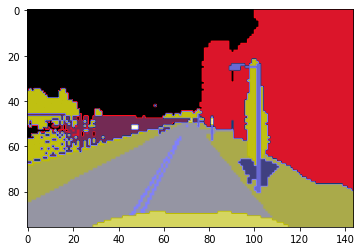

In [0]:
plt.imshow(data_front[0], cmap='gist_stern')

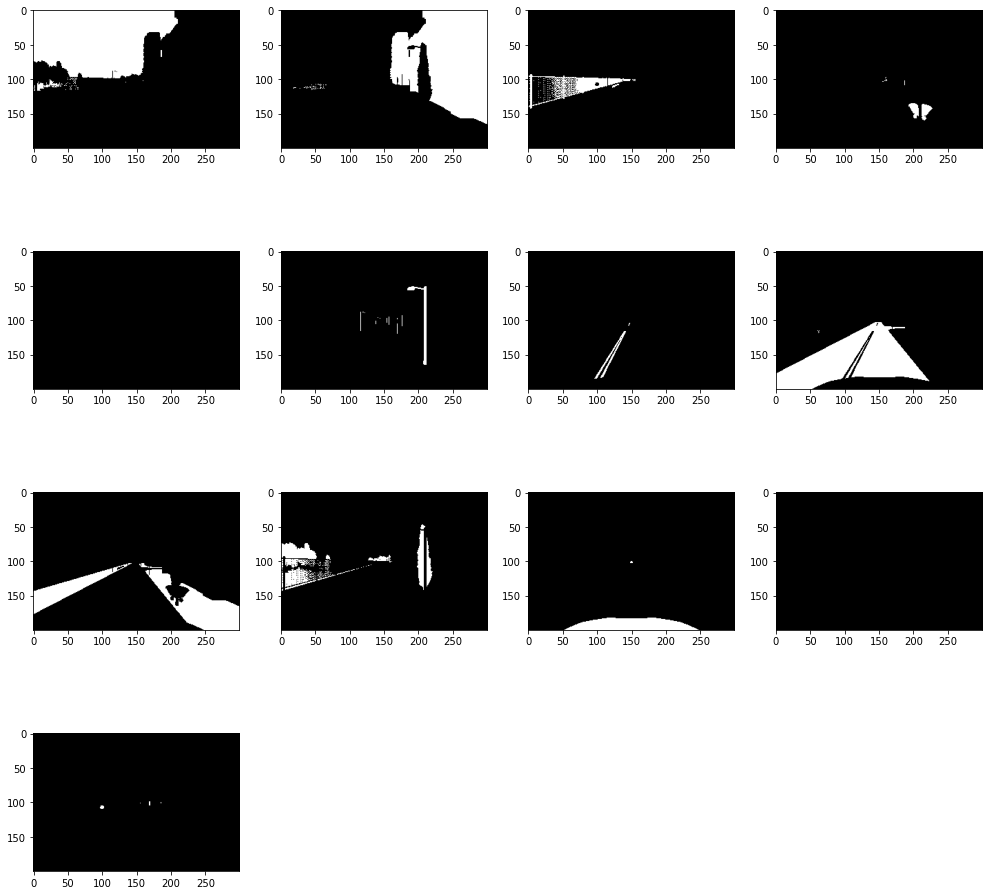

In [0]:
fig=plt.figure(figsize=(17, 17))
columns = 4
rows = 4
for i in range(13):
    img = individual_classes_front[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img, cmap='gray')
plt.show()

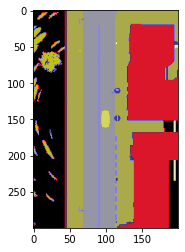

In [0]:
plt.imshow(data_top[0], cmap='gist_stern')

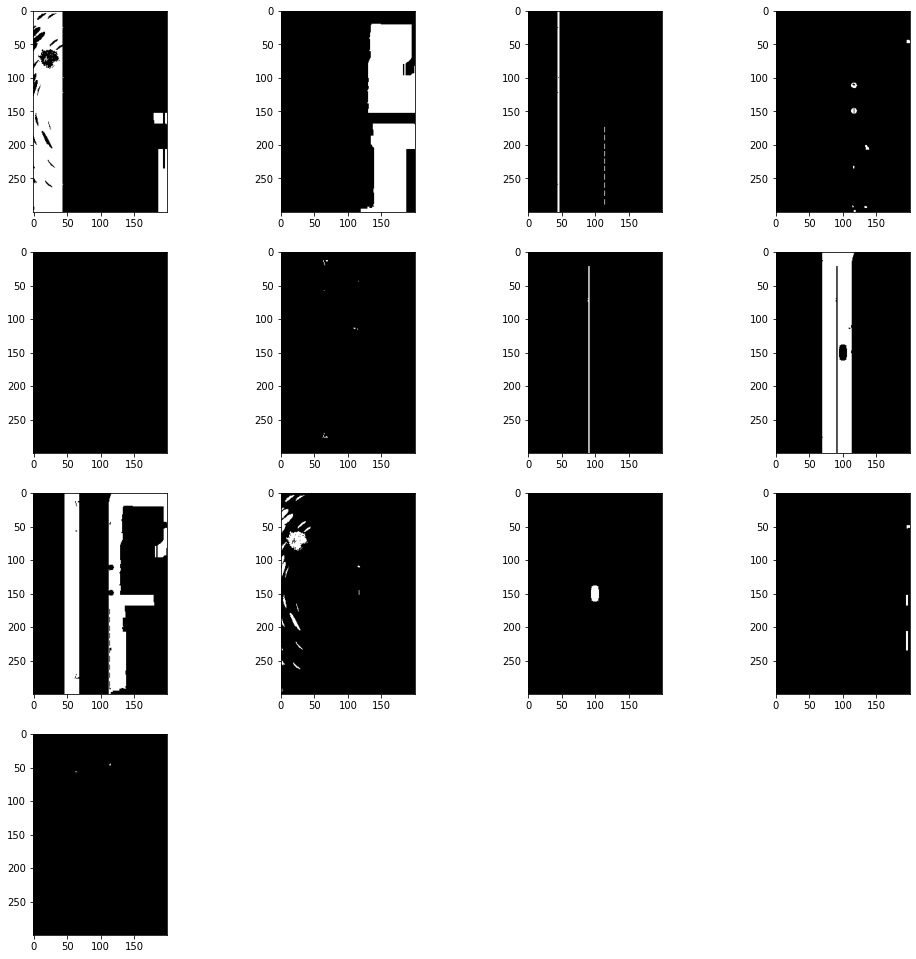

In [0]:
fig=plt.figure(figsize=(17, 17))
columns = 4
rows = 4
for i in range(13):
    img = individual_classes_top[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img, cmap='gray')
plt.show()


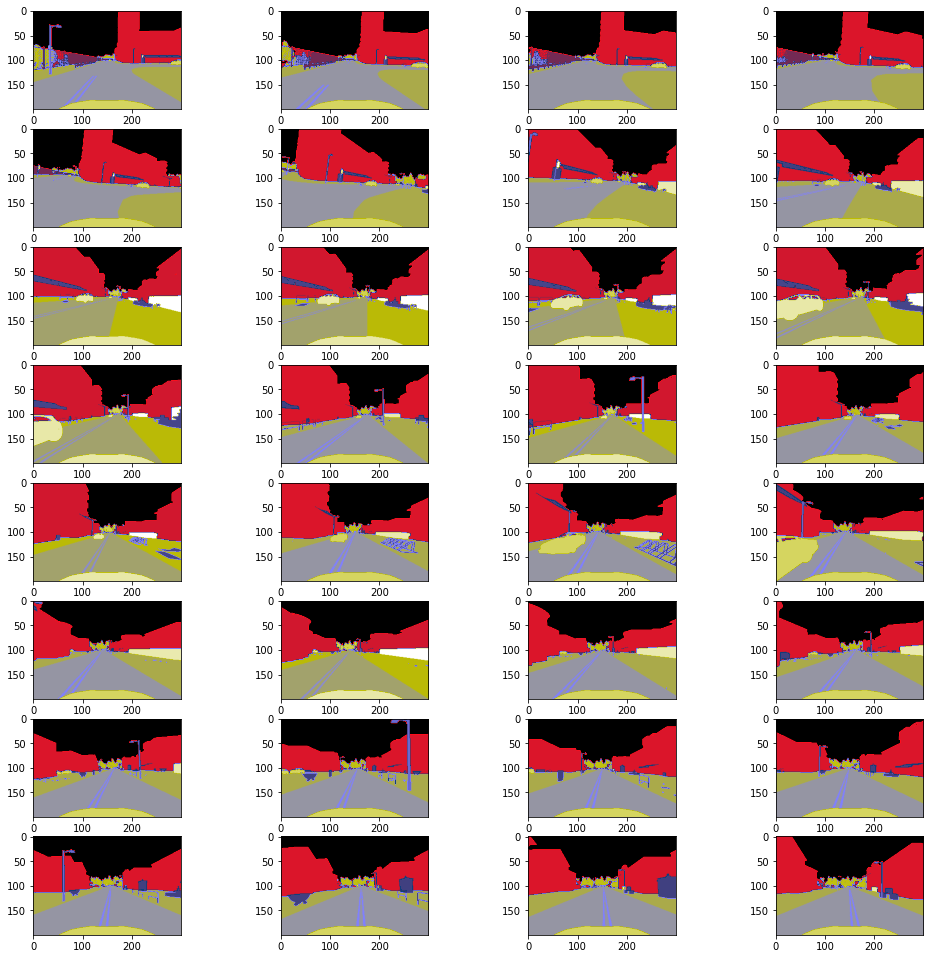

In [0]:
# The dataset is sampled at a high frame rate that causes dataset to be redundant. Use `rate` to specify good sampling rate.

fig=plt.figure(figsize=(17, 17))
columns = 4
rows = 8
start = 50
rate = 2

for j, i in enumerate(range(start, start + rows*columns*rate, rate)):
    fig.add_subplot(rows, columns, j+1)
    plt.imshow(data_front[i], cmap='gist_stern')
plt.show()

## Saving Data For later ReUse

In [0]:
file_names = os.listdir("./all/camera_storage")
file_names[:10]

['RightSS_Town02_29.npy',
 'TopSS_Town02_19.npy',
 'FrontSS_Town02_22.npy',
 'TopSS_Town02_40.npy',
 'FrontSS_Town01_37.npy',
 'LeftSS_Town02_22.npy',
 'FrontSS_Town02_38.npy',
 'RearSS_Town02_6.npy',
 'LeftSS_Town02_12.npy',
 'LeftSS_Town01_1.npy']

In [0]:
cameras = ['FrontSS', 'LeftSS' , 'RightSS',  'RearSS', 'TopSS']
towns = ['Town01', 'Town02']
mapping = {'FrontSS':'front', 'LeftSS':'left', 'RightSS':'right', 'TopSS': 'top', 'RearSS':'back'} 

In [0]:
os.mkdir('./data')
os.mkdir("./data/front")
os.mkdir("./data/left")
os.mkdir("./data/right")
os.mkdir("./data/top")
os.mkdir("./data/back")

In [0]:
sort_by_camera = {camera:[] for camera in cameras}
sort_by_camera

{'FrontSS': [], 'LeftSS': [], 'RearSS': [], 'RightSS': [], 'TopSS': []}

In [0]:
nums =[]
for filename in file_names:
  if 'FrontSS' in filename and 'Town02' in filename:
    num = int(filename.split('_')[-1].split('.')[0])
    nums.append(num)
nums = sorted(nums)

In [0]:
ordered_filenames = []

for town in towns:
  for camera in cameras:
    for num in nums:  
      name = camera + '_' + town + '_' + str(num) + '.npy'
      ordered_filenames.append(name)
      sort_by_camera[camera].append(name)

In [0]:
for camera in sort_by_camera:
  for filename in sort_by_camera[camera]:
    initial_path = "./all/camera_storage/" + filename
    
    if not os.path.isfile(initial_path):
      print('Some Problem With Data')
      break

In [0]:
df = pd.DataFrame(sort_by_camera)
df

,FrontSS,LeftSS,RightSS,RearSS,TopSS
0,FrontSS_Town01_0.npy,LeftSS_Town01_0.npy,RightSS_Town01_0.npy,RearSS_Town01_0.npy,TopSS_Town01_0.npy
1,FrontSS_Town01_1.npy,LeftSS_Town01_1.npy,RightSS_Town01_1.npy,RearSS_Town01_1.npy,TopSS_Town01_1.npy
2,FrontSS_Town01_2.npy,LeftSS_Town01_2.npy,RightSS_Town01_2.npy,RearSS_Town01_2.npy,TopSS_Town01_2.npy
3,FrontSS_Town01_3.npy,LeftSS_Town01_3.npy,RightSS_Town01_3.npy,RearSS_Town01_3.npy,TopSS_Town01_3.npy
4,FrontSS_Town01_4.npy,LeftSS_Town01_4.npy,RightSS_Town01_4.npy,RearSS_Town01_4.npy,TopSS_Town01_4.npy
...,...,...,...,...,...
87,FrontSS_Town02_41.npy,LeftSS_Town02_41.npy,RightSS_Town02_41.npy,RearSS_Town02_41.npy,TopSS_Town02_41.npy
88,FrontSS_Town02_100.npy,LeftSS_Town02_100.npy,RightSS_Town02_100.npy,RearSS_Town02_100.npy,TopSS_Town02_100.npy
89,FrontSS_Town02_101.npy,LeftSS_Town02_101.npy,RightSS_Town02_101.npy,RearSS_Town02_101.npy,TopSS_Town02_101.npy
90,FrontSS_Town02_102.npy,LeftSS_Town02_102.npy,RightSS_Town02_102.npy,RearSS_Town02_102.npy,TopSS_Town02_102.npy


In [0]:
for camera in sort_by_camera:
  file_num = 0
  for filename in sort_by_camera[camera]:
    initial_path = "./all/camera_storage/" + filename
    
    data = np.load(initial_path)
    data = np.moveaxis(data, -1, 0)
    if camera == 'TopSS':
      data = data.reshape(-1, 300, 200)
    else:
      data = data.reshape(-1, 200, 300)

    data = data[::2]  # sampling at rate = 2

    for img in data:
      save_path = "./data/" + mapping[camera] + '/' + str(file_num)
      np.save(save_path, img)  
      file_num += 1

  print(f'{camera} files done')

In [0]:
!rm -rf ./all

In [0]:
!zip -r 'birds_eye_data_final.zip' 'data'

In [0]:
!cp 'birds_eye_data_final.zip'  '/content/drive/My Drive/Self Driving/birds_eye_data_final.zip' 

## Reloading Data

In [5]:
Download = True #@param {type:"boolean"}

if Download:
  !gdown "https://drive.google.com/uc?id=1x0JdeA2Mo_QvYIJDHMfempoy2R675gMi" -O "birds_eye_data.zip"
else:
  !cp '/content/drive/My Drive/Self Driving/birds_eye_data_final.zip' 'birds_eye_data.zip' 

!unzip 'birds_eye_data.zip' 

Streaming output truncated to the last 5000 lines.
  inflating: data/right/32035.npy    
  inflating: data/right/32323.npy    
  inflating: data/right/35172.npy    
  inflating: data/right/12666.npy    
  inflating: data/right/35589.npy    
  inflating: data/right/31652.npy    
  inflating: data/right/38295.npy    
  inflating: data/right/27411.npy    
  inflating: data/right/45663.npy    
  inflating: data/right/13514.npy    
  inflating: data/right/36277.npy    
  inflating: data/right/29887.npy    
  inflating: data/right/8775.npy     
  inflating: data/right/29853.npy    
  inflating: data/right/12534.npy    
  inflating: data/right/3832.npy     
  inflating: data/right/32441.npy    
  inflating: data/right/41321.npy    
  inflating: data/right/17452.npy    
  inflating: data/right/16262.npy    
  inflating: data/right/45283.npy    
  inflating: data/right/22130.npy    
  inflating: data/right/13863.npy    
  inflating: data/right/5056.npy     
  inflating: data/right/45636.npy    

In [0]:
def plot_cameras(sequence_number):

  rows = 2
  columns = 3
  fig=plt.figure(figsize=(10, 10))
  imgs = []
  cameras = ['left', 'front','right', 'back','top']
  
  for i, camera in enumerate(cameras):
    sample = np.load(f"./data/{camera}/{sequence_number}.npy")
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(sample, cmap='gist_stern')

  plt.show()

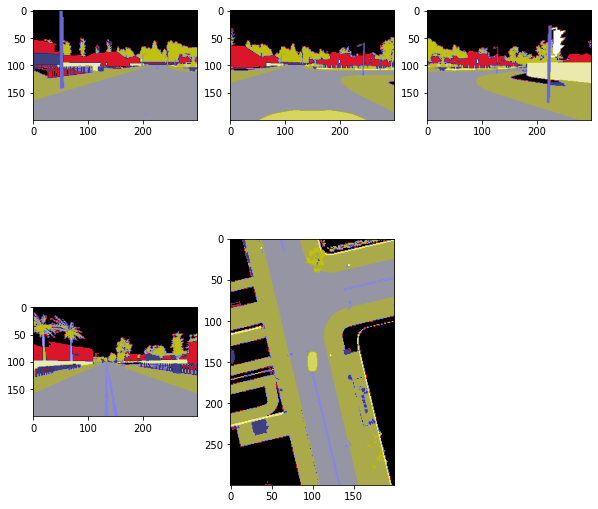

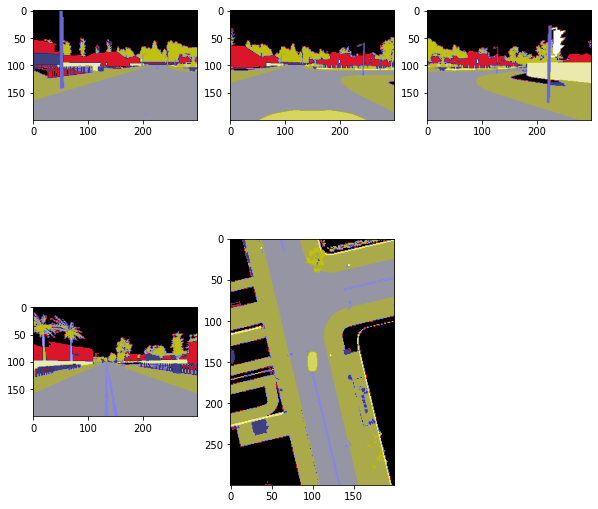

In [7]:
plot_cameras(100)

In [0]:
import os

def get_paths(val_size=5000):

  img_paths = []

  for i in range(len(os.listdir('./data/top'))):
    path = f'{i}.npy'
    img_paths.append(path)

  return pd.DataFrame({'path':img_paths[:-val_size]}), pd.DataFrame({'path':img_paths[-val_size:]})

In [9]:
img_paths_train, img_paths_val = get_paths()
img_paths_train

,path
0,0.npy
1,1.npy
2,2.npy
3,3.npy
4,4.npy
...,...
40995,40995.npy
40996,40996.npy
40997,40997.npy
40998,40998.npy


,path
0,0.npy
1,1.npy
2,2.npy
3,3.npy
4,4.npy
...,...
40995,40995.npy
40996,40996.npy
40997,40997.npy
40998,40998.npy


In [10]:
img_paths_val

,path
0,41000.npy
1,41001.npy
2,41002.npy
3,41003.npy
4,41004.npy
...,...
4995,45995.npy
4996,45996.npy
4997,45997.npy
4998,45998.npy


,path
0,41000.npy
1,41001.npy
2,41002.npy
3,41003.npy
4,41004.npy
...,...
4995,45995.npy
4996,45996.npy
4997,45997.npy
4998,45998.npy


## Setting up Data Generators

In [0]:
def img_to_categorical(img, needed_labels):
  
  cat = np.empty((img.shape[0], img.shape[1], len(needed_labels)))

  for channel, label in enumerate(needed_labels):
    cat[:, :, channel] = np.where(np.isin(img, label), 1, 0)

  return cat

def categorical_to_img(cat):
  
  cat = np.argmax(cat, axis=-1)
  return cat

needed_labels = [0, 1, 6, 7, 8, 10, 11]

In [0]:
from tensorflow.keras.utils import Sequence

class DataGenerator2D(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, img_paths, base_path, to_fit=True, batch_size=32, shuffle=True, needed_classes = []):
    
        self.img_paths = img_paths.copy()
        self.base_path = base_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.needed_classes = needed_classes
        self.on_epoch_end()
    
    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(len(self.img_paths) // self.batch_size)

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        current_indexes = list(range(index * self.batch_size, (index + 1) * self.batch_size))
        img_paths_temp = self.img_paths[current_indexes]

        # Generate data
        X = self._generate_X(img_paths_temp)

        if self.to_fit:
            y = self._generate_y(img_paths_temp)
            return X, y
        else:
            return X

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        if self.shuffle == True:
            indices = np.arange(len(self.img_paths))
            np.random.shuffle(indices)
            self.img_paths = self.img_paths[indices]
            self.img_paths.reset_index(drop=True, inplace=True)


    def _generate_X(self, img_paths_temp):
        """Generates data containing batch_size images
        :param img_paths_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization

        X = []

        # Generate data
        for idx, path in zip(img_paths_temp.index, img_paths_temp):
            # Store sample
            img = self._load_image(path)
            X.append(img)

        return np.array(X)

    def _generate_y(self, img_paths_temp):

        y = []

        for idx, path in zip(img_paths_temp.index, img_paths_temp):
            # Store sample
            img = self._load_image(path, front=False)
            y.append(img) 
        return np.array(y)

    def _load_image(self, image_path, front=True):
      
        if front:
          img_dir =  '/front/'
        else:
          img_dir =  '/top/'

        img = np.load(self.base_path + img_dir + image_path)
        img = img[::2, ::2]                                          # Downsampling image by factor of 2

        if not front:
          img = img[3:(img.shape[0]//2)]
          img = np.rot90(img)
          img = img[2:-2]                                           # Crop Image to make dimensions divisible by 8 
          img = img_to_categorical(img, self.needed_classes)

          return img
          
        img = img[2:-2, 3:-3]                                       # Crop Image to make dimensions divisible by 8 
        img = img_to_categorical(img, self.needed_classes)

        return img

In [0]:
train_generator = DataGenerator2D(img_paths_train['path'], './data', batch_size=32, shuffle=True, needed_classes=needed_labels)
val_generator = DataGenerator2D(img_paths_val['path'], './data', batch_size=1, shuffle=False, needed_classes=needed_labels)

In [15]:
# Test the generator

X, y = train_generator.__getitem__(0)
print(X.shape, y.shape)

(32, 96, 144, 7) (32, 96, 72, 7)


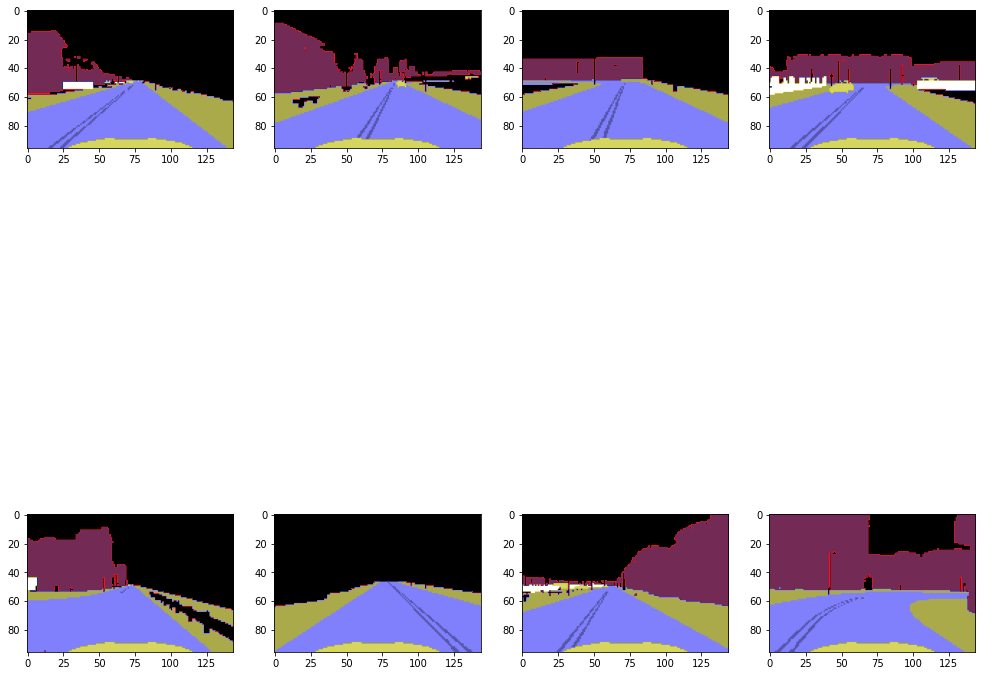

In [0]:
fig=plt.figure(figsize=(17, 17))
columns = 4
rows = 2
for i in range(1, columns*rows + 1):
    img = X[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(categorical_to_img(img), cmap='gist_stern', vmin=0, vmax=len(needed_labels)-1)
plt.show()

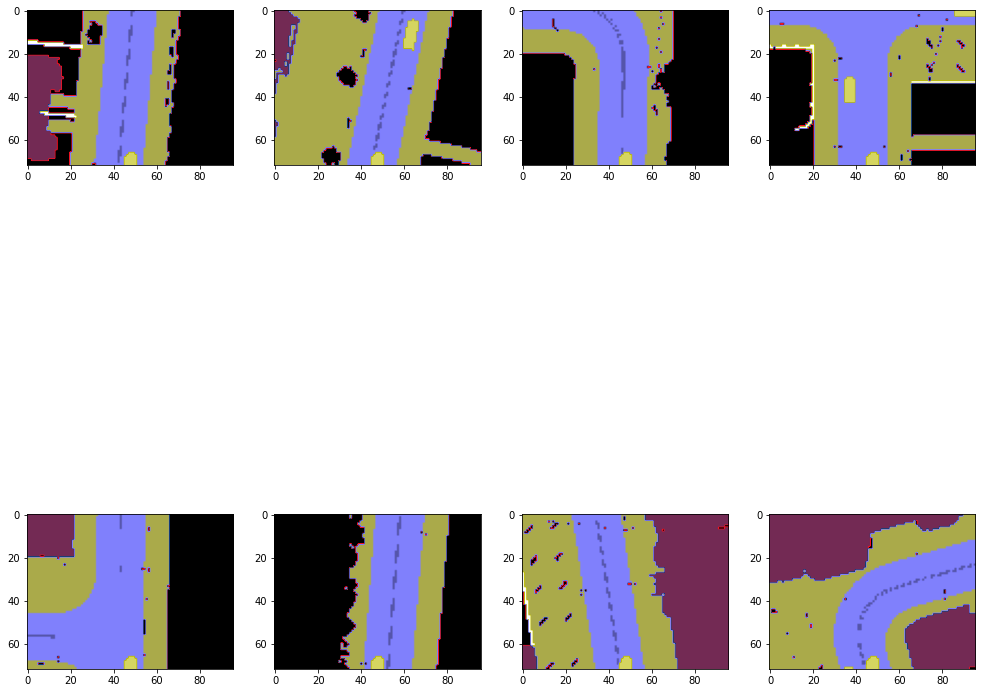

In [0]:
fig=plt.figure(figsize=(17, 17))
columns = 4
rows = 2
for i in range(1, columns*rows + 1):
    img = y[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.rot90(categorical_to_img(img), 3), cmap='gist_stern', vmin=0, vmax=len(needed_labels)-1)
plt.show()

In [0]:
import time
import keras.backend as K
from keras import Input, Model
from keras.layers import Convolution2D, LeakyReLU, BatchNormalization, UpSampling2D, Subtract, Concatenate, Softmax, Dropout, Activation,MaxPooling2D, Flatten, Dense, Lambda, Reshape, concatenate, ZeroPadding2D, Cropping2D
from keras.optimizers import Adam
from keras import Sequential

In [0]:
def build_unet_generator(needed_labels):

  """
  Create U-Net Generator using the hyperparameter values defined
  below
  """

  kernel_size = [8, 6, 4, 6, 6, 8]
  strides = 2
  leakyrelu_alpha = 0.2
  upsampling_size = 2
  output_channels = len(needed_labels)
  input_shape = (96, 144, len(needed_labels))

  # Setting up the input
  input_layer = Input(shape=input_shape)

  # Encoder Network

  # 1st Convolutional block in the encoder network
  encoder1 = Convolution2D(filters=64, kernel_size=8,
  padding='same',
  strides=strides)(input_layer)
  encoder1 = LeakyReLU(alpha=leakyrelu_alpha)(encoder1)
  # 2nd Convolutional block in the encoder network
  encoder2 = Convolution2D(filters=128, kernel_size=6,
  padding='same',
  strides=strides)(encoder1)
  encoder2 = BatchNormalization()(encoder2)
  encoder2 = LeakyReLU(alpha=leakyrelu_alpha)(encoder2)
  # 3rd Convolutional block in the encoder network
  encoder3 = Convolution2D(filters=256, kernel_size=4,
  padding='same',
  strides=strides)(encoder2)
  encoder3 = BatchNormalization()(encoder3)
  encoder3 = LeakyReLU(alpha=leakyrelu_alpha)(encoder3)

  # 6th Upsampling Convolutional block in the decoder network
  decoder6 = UpSampling2D(size=upsampling_size)(encoder3)
  decoder6 = Convolution2D(filters=128, kernel_size=6,
  padding='same')(decoder6)
  decoder6 = BatchNormalization()(decoder6)
  decoder6 = concatenate([decoder6, encoder2])
  decoder6 = LeakyReLU(alpha=leakyrelu_alpha)(decoder6)
  # 7th Upsampling Convolutional block in the decoder network
  decoder7 = UpSampling2D(size=upsampling_size)(decoder6)
  decoder7 = Convolution2D(filters=64, kernel_size=6,
  padding='same')(decoder7)
  decoder7 = BatchNormalization()(decoder7)
  decoder7 = concatenate([decoder7, encoder1])
  decoder7 = LeakyReLU(alpha=leakyrelu_alpha)(decoder7)


  # Last Convolutional layer
  decoder8 = UpSampling2D(size=(2, 1))(decoder7)
  decoder8 = Convolution2D(filters=output_channels,
  kernel_size=8, padding='same')(decoder8)
  decoder8 = Activation('softmax')(decoder8)

  model = Model(inputs=[input_layer], outputs=[decoder8])

  return model

In [0]:
def get_model(needed_labels):
    model = Sequential()
  
    model.add(Conv2D(16, (5, 5), strides=2, padding='same', input_shape=(96, 144, len(needed_labels))))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(32, (5, 5), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(64, (3, 3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(64, (3, 3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(UpSampling2D((2, 1)))
    model.add(Conv2D(16, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(len(needed_labels), (5, 5), activation='softmax', padding='same'))

    return model

model = get_model(needed_labels)
model.summary()

In [0]:
def get_model(needed_labels):
    model = Sequential()
  
    model.add(Conv2D(32, (5, 5), strides=2, padding='same', input_shape=(96, 144, len(needed_labels))))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(64, (5, 5), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(128, (3, 3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(128, (3, 3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(UpSampling2D((2, 1)))
    model.add(Conv2D(32, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(len(needed_labels), (5, 5), activation='softmax', padding='same'))

    return model

model = get_model(needed_labels)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 72, 32)        5632      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 72, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 48, 72, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 36, 64)        51264     
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 36, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 24, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 18, 128)      

In [0]:
model = build_unet_generator(needed_labels)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 96, 144, 7)   0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 48, 72, 64)   28736       input_6[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_26 (LeakyReLU)      (None, 48, 72, 64)   0           conv2d_31[0][0]                  
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 24, 36, 128)  295040      leaky_re_lu_26[0][0]             
____________________________________________________________________________________________

In [0]:
# Checking if the model can run at real time on current GPU at specifies fps

from time import time
fps = 30

x = np.random.random((96, 144, len(needed_labels)))
start = time()

for i in range(fps):
  out = model.predict(np.array([x]))

print(time() - start)

0.8795497417449951


In [0]:
from keras.optimizers import Nadam
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from time import time

optimizer = Nadam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
tensorboard = TensorBoard(log_dir="./drive/My Drive/Self Driving/logs/Birds Eye{}".format(time()))
early_stopping = EarlyStopping(monitor='val_loss', patience=30)

filepath = "./drive/My Drive/Self Driving/Birds Eye 2/" + "Birds Eye cat simple-2-" + "saved-model-{epoch:02d}-{val_loss:.5f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False)
callbacks_list = [checkpoint, tensorboard]

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels=len(needed_labels)):
    dice=0
    for index in range(0, numLabels):                                          
        dice -= dice_coef(y_true[:, :, :, index], y_pred[:, :, :, index])
    return numLabels + dice

def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def custom_loss(y_true, y_pred):
    return dice_coef_multilabel(y_true, y_pred) + 5*ssim_loss(y_true, y_pred)

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [0]:
# Simple FCN with small bottleneck results  (Crossentropy loss)

NUM_EPOCHS = 100

history = model.fit_generator(train_generator, epochs=NUM_EPOCHS, 
                              shuffle=True, callbacks=callbacks_list, 
                              validation_data= val_generator)

Epoch 1/100
   4/1281 [..............................] - ETA: 56:18 - loss: 1.6837 - categorical_accuracy: 0.3616  

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119830). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


1281/1281 [==============================] - 258s 201ms/step - loss: 0.5059 - categorical_accuracy: 0.7858 - val_loss: 0.2614 - val_categorical_accuracy: 0.8104

Epoch 00001: saving model to ./drive/My Drive/Self Driving/Birds Eye 2/Birds Eye cat simple-2-saved-model-01-0.26142.hdf5
Epoch 2/100
1281/1281 [==============================] - 227s 177ms/step - loss: 0.3595 - categorical_accuracy: 0.8442 - val_loss: 0.2692 - val_categorical_accuracy: 0.8393

Epoch 00002: saving model to ./drive/My Drive/Self Driving/Birds Eye 2/Birds Eye cat simple-2-saved-model-02-0.26919.hdf5
Epoch 3/100
1281/1281 [==============================] - 190s 148ms/step - loss: 0.3129 - categorical_accuracy: 0.8621 - val_loss: 0.2202 - val_categorical_accuracy: 0.8475

Epoch 00003: saving model to ./drive/My Drive/Self Driving/Birds Eye 2/Birds Eye cat simple-2-saved-model-03-0.22017.hdf5
Epoch 4/100
1281/1281 [==============================] - 180s 141ms/step - loss: 0.2828 - categorical_accuracy: 0.8733 - val

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-f312a0094672>", line 7, in <module>
    validation_data= val_generator)
  File "/usr/local/lib/python3.6/dist-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/training.py", line 1732, in fit_generator
    initial_epoch=initial_epoch)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py", line 220, in fit_generator
    reset_metrics=False)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/training.py", line 1514, in train_on_batch
    outputs = self.train_function(ins)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py", line 3792, in __call__
    outputs = self._graph_fn(*converted_inputs)
  File "/us

KeyboardInterrupt: ignored

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 438, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 421, in execute_request
    self._abort_queues()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 636, in _abort_queues
    self._abort_queue(stream)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 657, in _abort_queue
    sel

In [0]:
# Simple FCN with small bottleneck results (Dice Loss)

NUM_EPOCHS = 100

history = model.fit_generator(train_generator, epochs=NUM_EPOCHS, 
                              shuffle=True, callbacks=callbacks_list, 
                              validation_data= val_generator)

Epoch 1/100
82/82 [==============================] - 339s 4s/step - loss: 2.1354 - categorical_accuracy: 0.9006 - val_loss: 1.4038 - val_categorical_accuracy: 0.8805

Epoch 00001: saving model to ./drive/My Drive/Self Driving/Birds Eye/Birds Eye dice simple-2--saved-model-01-1.40381.hdf5
Epoch 2/100
82/82 [==============================] - 334s 4s/step - loss: 2.1289 - categorical_accuracy: 0.9015 - val_loss: 1.4538 - val_categorical_accuracy: 0.8808

Epoch 00002: saving model to ./drive/My Drive/Self Driving/Birds Eye/Birds Eye dice simple-2--saved-model-02-1.45381.hdf5
Epoch 3/100
82/82 [==============================] - 336s 4s/step - loss: 2.1264 - categorical_accuracy: 0.9016 - val_loss: 1.4570 - val_categorical_accuracy: 0.8800

Epoch 00003: saving model to ./drive/My Drive/Self Driving/Birds Eye/Birds Eye dice simple-2--saved-model-03-1.45697.hdf5
Epoch 4/100
82/82 [==============================] - 336s 4s/step - loss: 2.1228 - categorical_accuracy: 0.9022 - val_loss: 1.4259 - 

In [0]:
# U-Net Results (Not as good)

NUM_EPOCHS = 100

history = model.fit_generator(train_generator, epochs=NUM_EPOCHS, 
                              shuffle=True, callbacks=callbacks_list, 
                              validation_data= val_generator)

Epoch 1/100
5125/5125 [==============================] - 504s 98ms/step - loss: 0.6797 - categorical_accuracy: 0.7093 - val_loss: 0.5727 - val_categorical_accuracy: 0.6784

Epoch 00001: saving model to ./drive/My Drive/Self Driving/Birds Eye/Birds Eye 2-saved-model-01-0.57266.hdf5
Epoch 2/100
5125/5125 [==============================] - 506s 99ms/step - loss: 0.6323 - categorical_accuracy: 0.7288 - val_loss: 0.5737 - val_categorical_accuracy: 0.6951

Epoch 00002: saving model to ./drive/My Drive/Self Driving/Birds Eye/Birds Eye 2-saved-model-02-0.57371.hdf5
Epoch 3/100
5125/5125 [==============================] - 507s 99ms/step - loss: 0.6015 - categorical_accuracy: 0.7410 - val_loss: 0.6697 - val_categorical_accuracy: 0.7013

Epoch 00003: saving model to ./drive/My Drive/Self Driving/Birds Eye/Birds Eye 2-saved-model-03-0.66973.hdf5
Epoch 4/100
5125/5125 [==============================] - 509s 99ms/step - loss: 0.5790 - categorical_accuracy: 0.7499 - val_loss: 0.5797 - val_categorical

## Testing the model

In [0]:
from keras.models import load_model

model = load_model('./drive/My Drive/Self Driving/Birds Eye 2/Birds Eye cat simple-2-saved-model-74-0.06621.hdf5', compile=False)

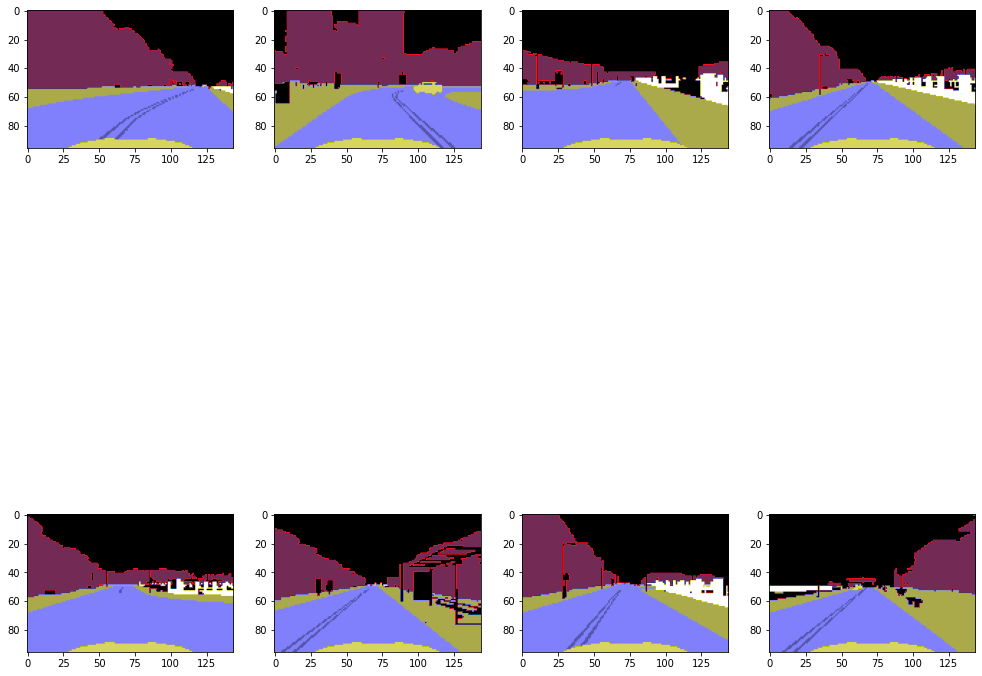

In [0]:
fig=plt.figure(figsize=(17, 17))
columns = 4
rows = 2
for i in range(1, columns*rows + 1):
    img = X[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(categorical_to_img(img), cmap='gist_stern', vmin=0, vmax=len(needed_labels) - 1)
plt.show()

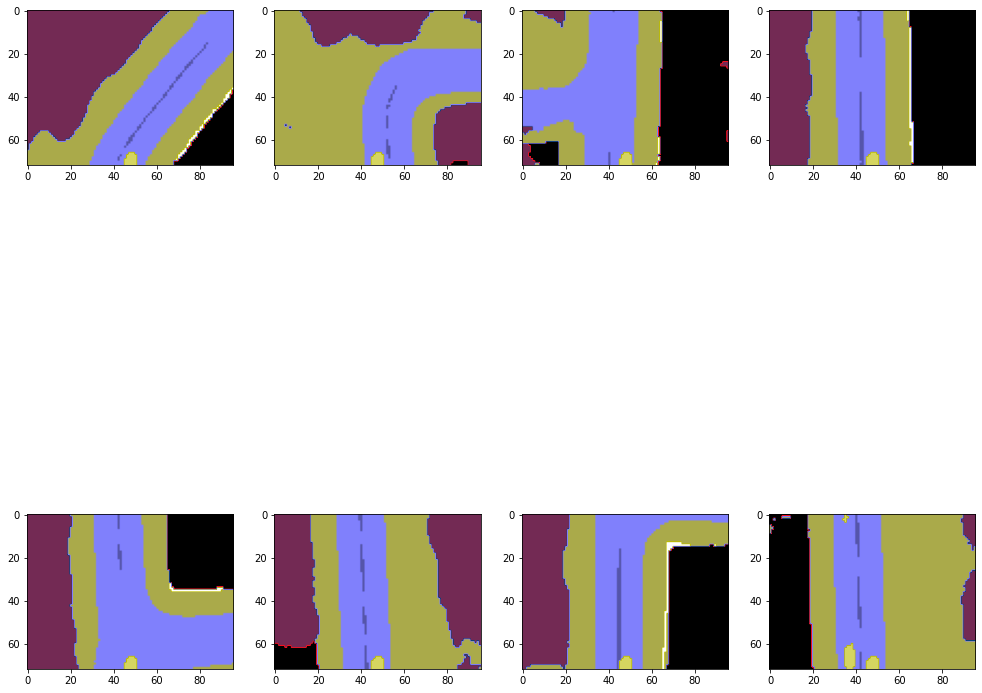

In [0]:
fig=plt.figure(figsize=(17, 17))
columns = 4
rows = 2
for i in range(1, columns*rows + 1):
    img = X[i-1]
    pred = model.predict(np.array([img]))
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.rot90(categorical_to_img(pred[0]), 3), cmap='gist_stern', vmin=0, vmax=len(needed_labels)-1)
plt.show()

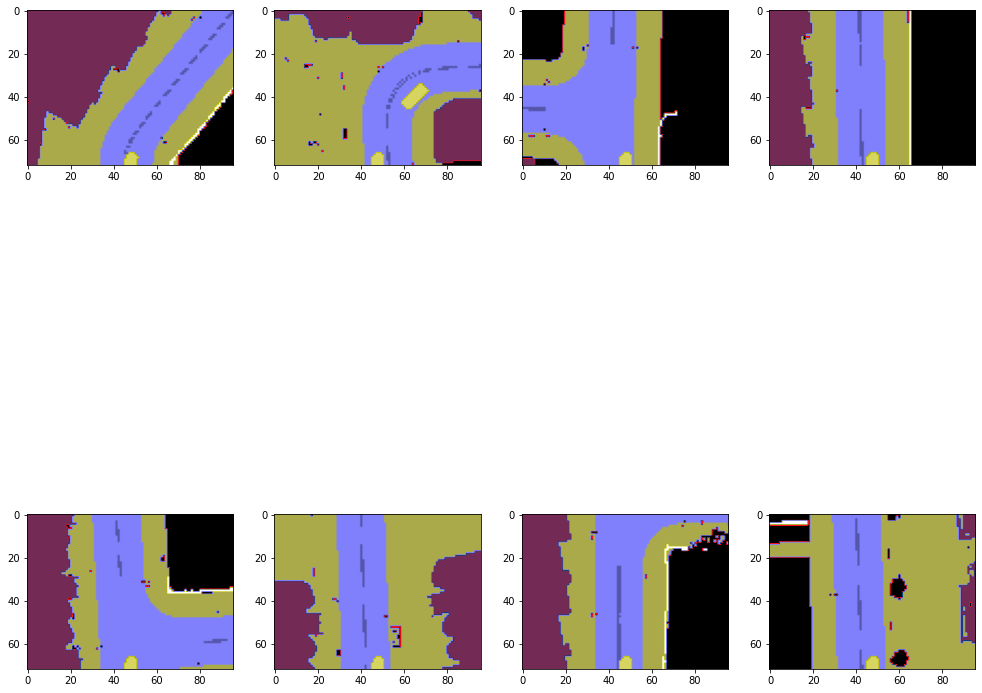

In [0]:
fig=plt.figure(figsize=(17, 17))
columns = 4
rows = 2
for i in range(1, columns*rows + 1):
    img = y[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.rot90(categorical_to_img(img), 3), cmap='gist_stern', vmin=0, vmax=len(needed_labels)-1)

In [0]:
## Use this and play video on your own pc by loading the numpy array.

imgs = []

for i in range(len(X)):
  img = X[i]
  pred = model.predict(np.array([img]))
  img = np.rot90(categorical_to_img(pred[0]), 3)
  imgs.append(img.astype('uint8'))

np.save('output7', np.array(imgs))

## Other Experimentation (Ignore)

In [0]:
## Dosen't works for now

import cv2
import numpy as np

video = cv2.VideoWriter("output.avi", cv2.VideoWriter_fourcc(*"MJPG"), 15,(96,144))

for i in range(10):
    img = X[i]
    pred = model.predict(np.array([img]))
    img = np.rot90(categorical_to_img(pred[0]), 3)
    video.write(img.reshape(img.shape[0], img.shape[1]))

cv2.destroyAllWindows()
video.release()

In [0]:
# Ignore

alternative_multi_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_from_FrontSS (InputLayer) (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
input_from_LeftSS (InputLayer)  (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
input_from_RightSS (InputLayer) (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
input_from_RearSS (InputLayer)  (None, 256, 256, 1)  0                                            
____________________________________________________________________________________________

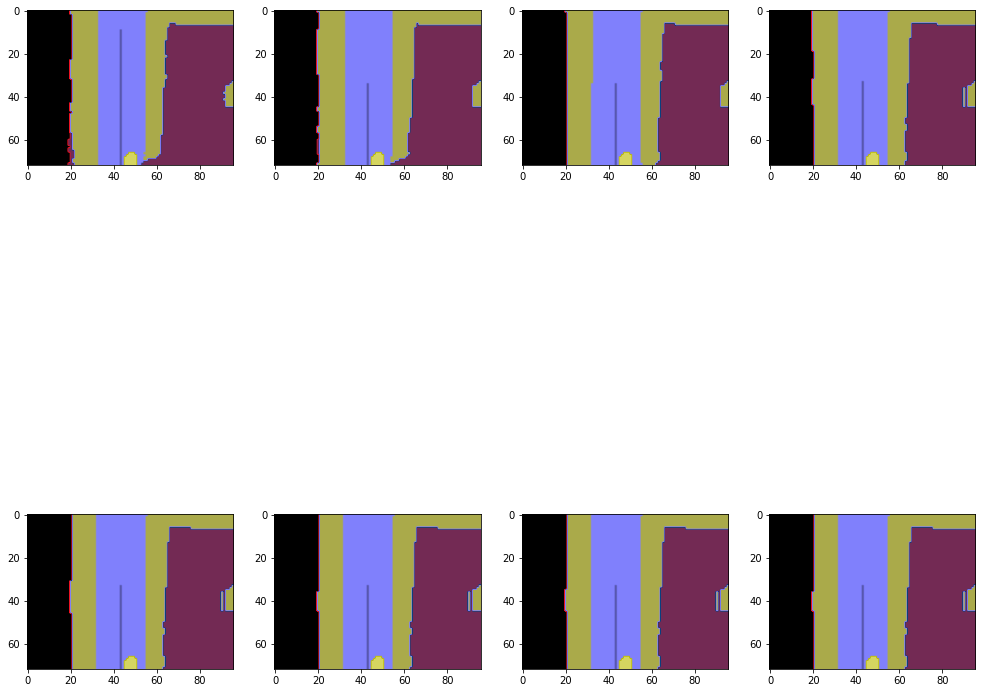

In [0]:
# Crossentropy Overfitting       (Works)

fig=plt.figure(figsize=(17, 17))
columns = 4
rows = 2
for i in range(1, columns*rows + 1):
    X, y = train_generator.__getitem__(i-1)
    img = X[0]
    pred = model.predict(np.array([img]))
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.rot90(categorical_to_img(pred[0]), 3), cmap='gist_stern', vmin=0, vmax=len(needed_labels)-1)
plt.show()

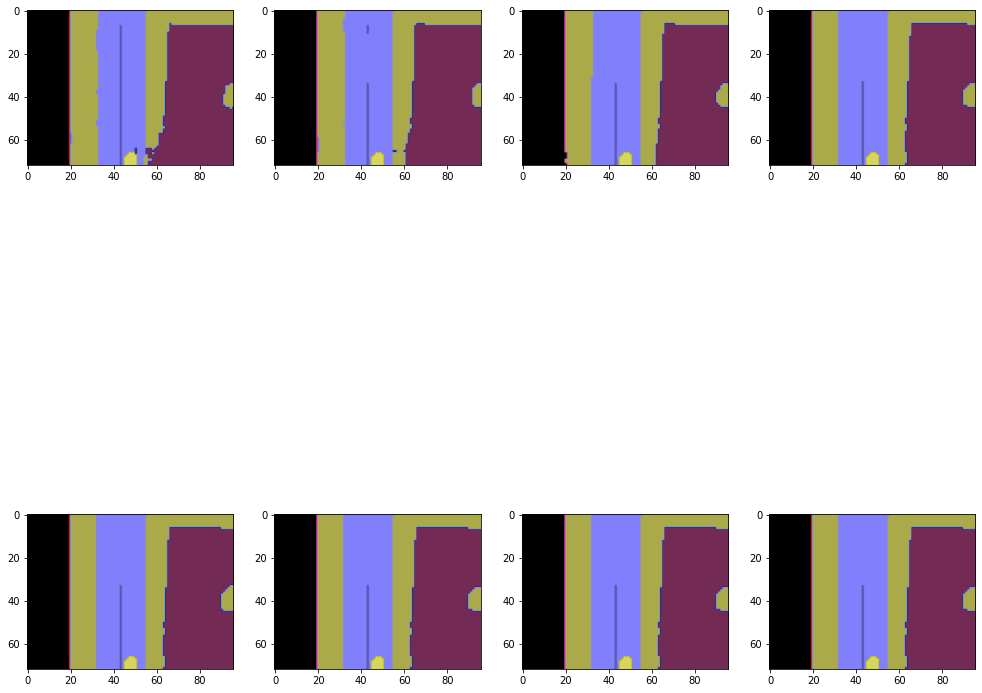

In [0]:
# Dice Overfitting                 (Works)

fig=plt.figure(figsize=(17, 17))
columns = 4
rows = 2
for i in range(1, columns*rows + 1):
    X, y = train_generator.__getitem__(i-1)
    img = X[0]
    pred = model.predict(np.array([img]))
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.rot90(categorical_to_img(pred[0]), 3), cmap='gist_stern', vmin=0, vmax=len(needed_labels)-1)
plt.show()

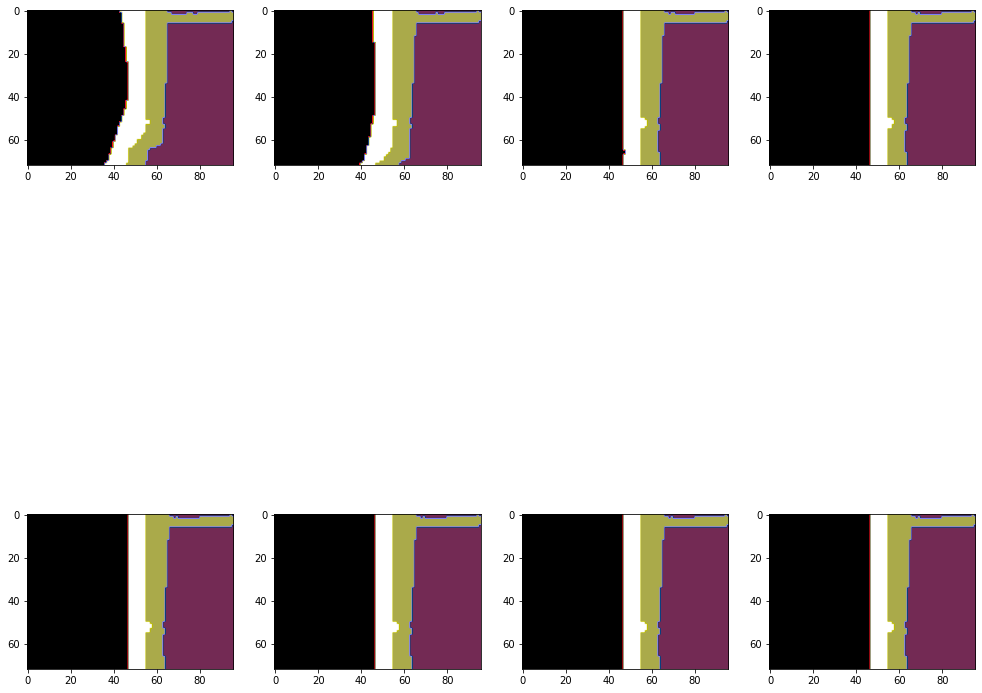

In [0]:
# SSIM Overfitting                   (It's messed up, means needs changes)

fig=plt.figure(figsize=(17, 17))
columns = 4
rows = 2
for i in range(1, columns*rows + 1):
    X, y = train_generator.__getitem__(i)
    img = X[0]
    pred = model.predict(np.array([img]))
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.rot90(categorical_to_img(pred[0]), 3), cmap='gist_stern', vmin=0, vmax=len(needed_labels)-1)
plt.show()

## Performing SLAM

In [0]:
# Restart runtime after this.

!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

In [43]:
train_generator = DataGenerator2D(img_paths_train['path'], './data', batch_size=100, shuffle=False, needed_classes=needed_labels)

X, y = train_generator.__getitem__(0)
print(X.shape, y.shape)

(100, 96, 144, 7) (100, 96, 72, 7)


In [0]:
imgs = categorical_to_img(y)
imgs = imgs.reshape(-1, 96, 72)
imgs = imgs.astype('uint8')

In [0]:
def auto_canny(image, sigma=0.33):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)
	# return the edged image
	return edged

In [0]:
def get_roads(img):
  road = np.where(np.isin(img, 3), 1, 0)
  #road = cv2.GaussianBlur(road.astype('uint8'), (5,5), 0)
  edges = auto_canny(road.astype('uint8'))

  return edges

In [0]:
road_edges = []

for img in imgs:
  road_edge = get_roads(img)
  road_edges.append(road_edge)

plt.imshow(pred, cmap='Greys')

In [0]:
np.save('images1', np.array(imgs), 'uint8')

In [0]:
np.save('edges1', np.array(road_edges))

In [0]:
maps = {0: [5, 5, 5], 1: [194, 28, 10], 2:[255, 255, 255], 3 :[153, 156, 156], 4:[61, 61, 61], 5:[21, 131, 214], 6:[204, 61, 61]}

def index_to_rgb(img, maps=maps):

  test = np.zeros((img.shape[0], img.shape[1], 3))
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):

      test[i, j, :] = np.array(maps[img[i, j]])

  return test

In [0]:
imgs_rgb = []

for img in imgs:
  img_rgb = index_to_rgb(img)
  imgs_rgb.append(img_rgb)

imgs_rgb = np.array(imgs_rgb, dtype='uint8')

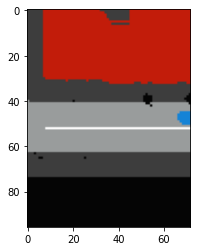

In [49]:
plt.imshow(imgs_rgb[0])

In [0]:
for i, img in enumerate(imgs_rgb):
  cv2.imwrite(f'imgs/{i}.jpg', img)

In [0]:
stitcher = cv2.createStitcher()
(status, stitched) = stitcher.stitch(imgs_rgb[:10])
print(status)

1


In [0]:
base_img = cv2.GaussianBlur(imgs_rgb[0], (3,3), 0)
next_img = cv2.GaussianBlur(imgs_rgb[5], (3,3), 0)

#use SIFT feature detector
detector = cv2.xfeatures2d.SIFT_create()

# Parameters for nearest-neighbor matching
FLANN_INDEX_KDTREE = 1
flann_params = dict(algorithm = FLANN_INDEX_KDTREE, 
    trees = 5)
matcher = cv2.FlannBasedMatcher(flann_params, {})

In [0]:
base_features, base_descs = detector.detectAndCompute(base_img, None)
next_features, next_descs = detector.detectAndCompute(next_img, None)

matches = matcher.knnMatch(base_descs, trainDescriptors=next_descs, k=2)
matches = np.array(matches)

In [0]:
kp1 = []
kp2 = []

for match in matches[:,1]:
    kp1.append(base_features[match.trainIdx])
    kp2.append(next_features[match.queryIdx])

p1 = np.array([k.pt for k in kp1])
p2 = np.array([k.pt for k in kp2])

H, status = cv2.findHomography(p1, p2, cv2.RANSAC, 5.0)

# how successful the transformation was
print ('%d / %d  inliers/matched' % (np.sum(status), len(status)))

6 / 13  inliers/matched


In [0]:
good = []
for m in matches:
  if m[0].distance < 0.5*m[1].distance:
    good.append(m)
matches = np.asarray(good)

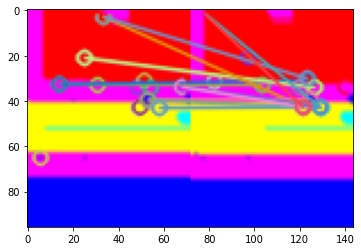

In [0]:
img3 = cv2.drawMatchesKnn(base_img,base_features,next_img,next_features,matches,None)

plt.imshow(img3)

In [0]:
src = np.float32([ base_features[m.queryIdx].pt for m in matches[:len(base_features),0] ]).reshape(-1,1,2)
dst = np.float32([ next_features[m.trainIdx].pt for m in matches[:len(base_features),0] ]).reshape(-1,1,2)

In [0]:
H, masked = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)

In [0]:
H

array([[-3.08721147,  3.39138888, 26.56150536],
       [-2.07633992,  2.36997192, 14.97089441],
       [-0.07134458,  0.06779043,  1.        ]])

In [0]:
dst = cv2.warpPerspective(next_img, H, (base_img.shape[1] + next_img.shape[1], base_img.shape[0]))

In [0]:
def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """

    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"

    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()

    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)

    return (kps, features)

In [0]:
base_img = imgs_rgb[0]
next_img = imgs_rgb[10]

In [0]:
kps1, features1 = detectAndDescribe(base_img, method='surf')
kps2, features2 = detectAndDescribe(next_img, method='surf')

In [0]:
matches = matcher.knnMatch(features2, trainDescriptors=features1, k=2)
matches = np.array(matches)

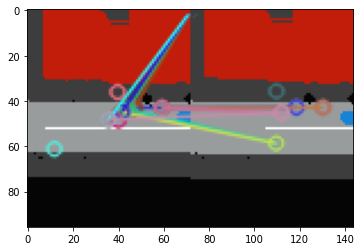

In [0]:
img3 = cv2.drawMatchesKnn(base_img ,kps1, next_img, kps2, matches, None)

plt.imshow(img3)

In [0]:
#!/usr/bin/python

import os
import sys
import cv2
import math
import numpy as np
from numpy import linalg



class Stitch(object):
 
    def __init__(self, image_dir, key_frame, output_dir, img_filter=None):
        '''
        image_dir: 'directory' containing all images
        key_frame: 'dir/name.jpg' of the base image
        output_dir: 'directory' where to save output images
        optional: 
           img_filter = 'JPG'; None->Take all images
        '''
    
        self.key_frame_file = os.path.split(key_frame)[-1]
        self.output_dir = output_dir
        
        
        # Open the directory given in the arguments
        self.dir_list = []
        try:
            self.dir_list = os.listdir(image_dir)
            if img_filter:
                # remove all files that doen't end with .[image_filter]
                self.dir_list = filter(lambda x: x.find(img_filter) > -1, self.dir_list)
            try: #remove Thumbs.db, is existent (windows only)
                self.dir_list.remove('.DS_Store')
            except ValueError:
                pass
                
        
        except:

            sys.exit(-1)
    
        self.dir_list = map(lambda x: os.path.join(image_dir, x), self.dir_list)
        
        self.dir_list = filter(lambda x: x != key_frame, self.dir_list)
    
        base_img_rgb = cv2.imread(key_frame)
        if base_img_rgb == None:
            raise IOError("%s doesn't exist" %key_frame)
        
        final_img = self.stitch(base_img_rgb, 0)        
        


    def filter_matches(self, matches, ratio = 0.75):
        filtered_matches = []
        for m in matches:
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                filtered_matches.append(m[0])
        
        return filtered_matches
    
    def imageDistance(self, matches):
    
        sumDistance = 0.0
    
        for match in matches:
    
            sumDistance += match.distance
    
        return sumDistance
    
    def findDimensions(self, image, homography):
        base_p1 = np.ones(3, np.float32)
        base_p2 = np.ones(3, np.float32)
        base_p3 = np.ones(3, np.float32)
        base_p4 = np.ones(3, np.float32)
    
        (y, x) = image.shape[:2]
    
        base_p1[:2] = [0,0]
        base_p2[:2] = [x,0]
        base_p3[:2] = [0,y]
        base_p4[:2] = [x,y]
    
        max_x = None
        max_y = None
        min_x = None
        min_y = None
    
        for pt in [base_p1, base_p2, base_p3, base_p4]:
    
            hp = np.matrix(homography, np.float32) * np.matrix(pt, np.float32).T
    
            hp_arr = np.array(hp, np.float32)
    
            normal_pt = np.array([hp_arr[0]/hp_arr[2], hp_arr[1]/hp_arr[2]], np.float32)
    
            if ( max_x == None or normal_pt[0,0] > max_x ):
                max_x = normal_pt[0,0]
    
            if ( max_y == None or normal_pt[1,0] > max_y ):
                max_y = normal_pt[1,0]
    
            if ( min_x == None or normal_pt[0,0] < min_x ):
                min_x = normal_pt[0,0]
    
            if ( min_y == None or normal_pt[1,0] < min_y ):
                min_y = normal_pt[1,0]
    
        min_x = min(0, min_x)
        min_y = min(0, min_y)
    
        return (min_x, min_y, max_x, max_y)

    
    def stitch(self, base_img_rgb, round=0):
    
        if ( len(self.dir_list) < 1 ):
            return base_img_rgb 
    
    
        base_img = cv2.GaussianBlur(cv2.cvtColor(base_img_rgb,cv2.COLOR_BGR2GRAY), (5,5), 0)
    
        # Use the SIFT feature detector
        detector = cv2.xfeatures2d.SIFT_create()
    
        # Find key points in base image for motion estimation
        base_features, base_descs = detector.detectAndCompute(base_img, None)
    
        # Parameters for nearest-neighbor matching
        FLANN_INDEX_KDTREE = 1
        flann_params = dict(algorithm = FLANN_INDEX_KDTREE, 
            trees = 5)
        matcher = cv2.FlannBasedMatcher(flann_params, {})

    
        closestImage = None
    
        next_img_path = self.dir_list[0]


        # Read in the next image...
        next_img_rgb = cv2.imread(next_img_path)
        next_img = cv2.GaussianBlur(cv2.cvtColor(next_img_rgb,cv2.COLOR_BGR2GRAY), (5,5), 0)



        # Find points in the next frame
        next_features, next_descs = detector.detectAndCompute(next_img, None)

        matches = matcher.knnMatch(next_descs, trainDescriptors=base_descs, k=2)


        matches_subset = self.filter_matches(matches)

        

        distance = self.imageDistance(matches_subset)

        averagePointDistance = distance/float(len(matches_subset))


        kp1 = []
        kp2 = []

        for match in matches_subset:
            kp1.append(base_features[match.trainIdx])
            kp2.append(next_features[match.queryIdx])

        p1 = np.array([k.pt for k in kp1])
        p2 = np.array([k.pt for k in kp2])

        H, status = cv2.findHomography(p1, p2, cv2.RANSAC, 5.0)
     
        inlierRatio = float(np.sum(status)) / float(len(status))

        if ( closestImage == None or inlierRatio > closestImage['inliers'] ):
            closestImage = {}
            closestImage['h'] = H
            closestImage['inliers'] = inlierRatio
            closestImage['dist'] = averagePointDistance
            closestImage['path'] = next_img_path
            closestImage['rgb'] = next_img_rgb
            closestImage['img'] = next_img
            closestImage['feat'] = next_features
            closestImage['desc'] = next_descs
            closestImage['match'] = matches_subset
    
        

        self.dir_list = filter(lambda x: x != closestImage['path'], self.dir_list)
    
        H = closestImage['h']
        H = H / H[2,2]
        H_inv = linalg.inv(H)
    
        if ( closestImage['inliers'] > 0.1 ): # and 
    
            (min_x, min_y, max_x, max_y) = self.findDimensions(closestImage['img'], H_inv)
    
            # Adjust max_x and max_y by base img size
            max_x = max(max_x, base_img.shape[1])
            max_y = max(max_y, base_img.shape[0])
    
            move_h = np.matrix(np.identity(3), np.float32)
    
            if ( min_x < 0 ):
                move_h[0,2] += -min_x
                max_x += -min_x
    
            if ( min_y < 0 ):
                move_h[1,2] += -min_y
                max_y += -min_y
    
      
    
            mod_inv_h = move_h * H_inv
    
            img_w = int(math.ceil(max_x))
            img_h = int(math.ceil(max_y))
    

            # crop edges
       
            base_h, base_w, base_d = base_img_rgb.shape
            next_h, next_w, next_d = closestImage['rgb'].shape

            base_img_rgb = base_img_rgb[5:(base_h-5),5:(base_w-5)]
            closestImage['rgb'] = closestImage['rgb'][5:(next_h-5),5:(next_w-5)]

    
            # Warp the new image given the homography from the old image
            base_img_warp = cv2.warpPerspective(base_img_rgb, move_h, (img_w, img_h))
         
    
            # utils.showImage(base_img_warp, scale=(0.2, 0.2), timeout=1000, save=True, title="base_img_warp")
            # cv2.destroyAllWindows()
    
            next_img_warp = cv2.warpPerspective(closestImage['rgb'], mod_inv_h, (img_w, img_h))
     
    
            # utils.showImage(next_img_warp, scale=(0.2, 0.2), timeout=1000, save=True, title="next_img_warp")
            # cv2.destroyAllWindows()
    
            # Put the base image on an enlarged palette
            enlarged_base_img = np.zeros((img_h, img_w, 3), np.uint8)
    
 
            # enlarged_base_img[y:y+base_img_rgb.shape[0],x:x+base_img_rgb.shape[1]] = base_img_rgb
            # enlarged_base_img[:base_img_warp.shape[0],:base_img_warp.shape[1]] = base_img_warp
    
            # Create masked composite
            (ret,data_map) = cv2.threshold(cv2.cvtColor(next_img_warp, cv2.COLOR_BGR2GRAY), 
                0, 255, cv2.THRESH_BINARY)

            # add base image
            enlarged_base_img = cv2.add(enlarged_base_img, base_img_warp, 
                mask=np.bitwise_not(data_map), 
                dtype=cv2.CV_8U)
    
            # add next image
            final_img = cv2.add(enlarged_base_img, next_img_warp, 
                dtype=cv2.CV_8U)
    
            # Crop black edge
            final_gray = cv2.cvtColor(final_img, cv2.COLOR_BGR2GRAY)
            _, thresh = cv2.threshold(final_gray, 1, 255, cv2.THRESH_BINARY)
            dino, contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
          
    
            max_area = 0
            best_rect = (0,0,0,0)
    
            for cnt in contours:
                x,y,w,h = cv2.boundingRect(cnt)
    
                deltaHeight = h-y
                deltaWidth = w-x
    
                area = deltaHeight * deltaWidth
    
                if ( area > max_area and deltaHeight > 0 and deltaWidth > 0):
                    max_area = area
                    best_rect = (x,y,w,h)
    
            if ( max_area > 0 ):
                final_img_crop = final_img[best_rect[1]:best_rect[1]+best_rect[3],
                        best_rect[0]:best_rect[0]+best_rect[2]]
    
                final_img = final_img_crop
    
            # output
            final_filename = "%s/%d.JPG" % (self.output_dir, round)
            cv2.imwrite(final_filename, final_img)
    
            return self.stitch(final_img, round+1)
    
        else:
    
            return self.stitchImages(base_img_rgb, round+1)
    


In [0]:
Stitch('imgs', 'imgs/1.jpg', 'outs')